In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

import io
import itertools
import os
import warnings

import re
import string
import json
import requests
import shapely

from pysal.model import mgwr
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import time
import re 
import pandas as pd 
import geopandas as gpd
import numpy as np

from requests import get
from urllib.parse import urlparse

DATA_DIR = "../data"
SRC_BOROS = 'https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true'
DEST_BOROS  = os.path.join(DATA_DIR,'geo')

def set_proxy(port:int):
    '''
    set vpn for python environment if time zone is +8
    
    :param port: 
    :return  :
    '''
    tz = time.strftime('%z')
    if tz == "+0800": 
        os.environ['HTTP_PROXY'] = f'http://127.0.0.1:{port}'
        os.environ['HTTPS_PROXY'] = f'http://127.0.0.1:{port}'
        print("proxy setted")
    else:
        print(f"Time zone: {tz}")
        
def cache_data(src:str, dest:str)->str:
    '''
    copied from jon
    
    :param src: source url
    :param dest: destination directory
    :return dfn: destination directory + filename
    '''
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print(f"\tDone downloading.")

    else:
        print(f"Found {dfn} locally!")
        
    return dfn

def df_to_gdf(df, lon="longitude", lat="latitude",scproj='epsg:4326',proj='epsg:27700'):
    '''
    transform dataframe to geopandas dataframe
    
    :param scproj:source projection
    :param proj: target projection
    :return gdf: geodataframe
    '''
    dft = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon], df[lat], crs=scproj))
    gdf = dft.to_crs(proj).drop(columns=[lon,lat],axis=1)
    print(f"Geo Data frame is {gdf.shape[0]} x {gdf.shape[1]}")
    return gdf

In [7]:
## preparation =============================================================

#warnings.filterwarnings(action='once') ## 
warnings.filterwarnings('ignore') ## Hide all warnings in ipython

# os.chdir("E:/200_CASA/13_i2p-py/London_Airbnb") ## set current working directory 
#os.makedirs(DATA_DIR) ## create data dir

set_proxy(10809)

pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places

proxy setted


## Load data 

In [8]:
df_searchers = pd.read_csv(DATA_DIR+"/searches.csv")
gdf_seachers = df_to_gdf(df_searchers, lon="longitude", lat="latitude",scproj='epsg:4326',proj='epsg:27700')

Geo Data frame is 547 x 11


In [9]:
## load boroughs gpkg as gdf
gdf_boros = gpd.read_file( cache_data(SRC_BOROS, DEST_BOROS) )

Found ../data\geo\Boroughs.gpkg locally!


-5 raws removed


<AxesSubplot:>

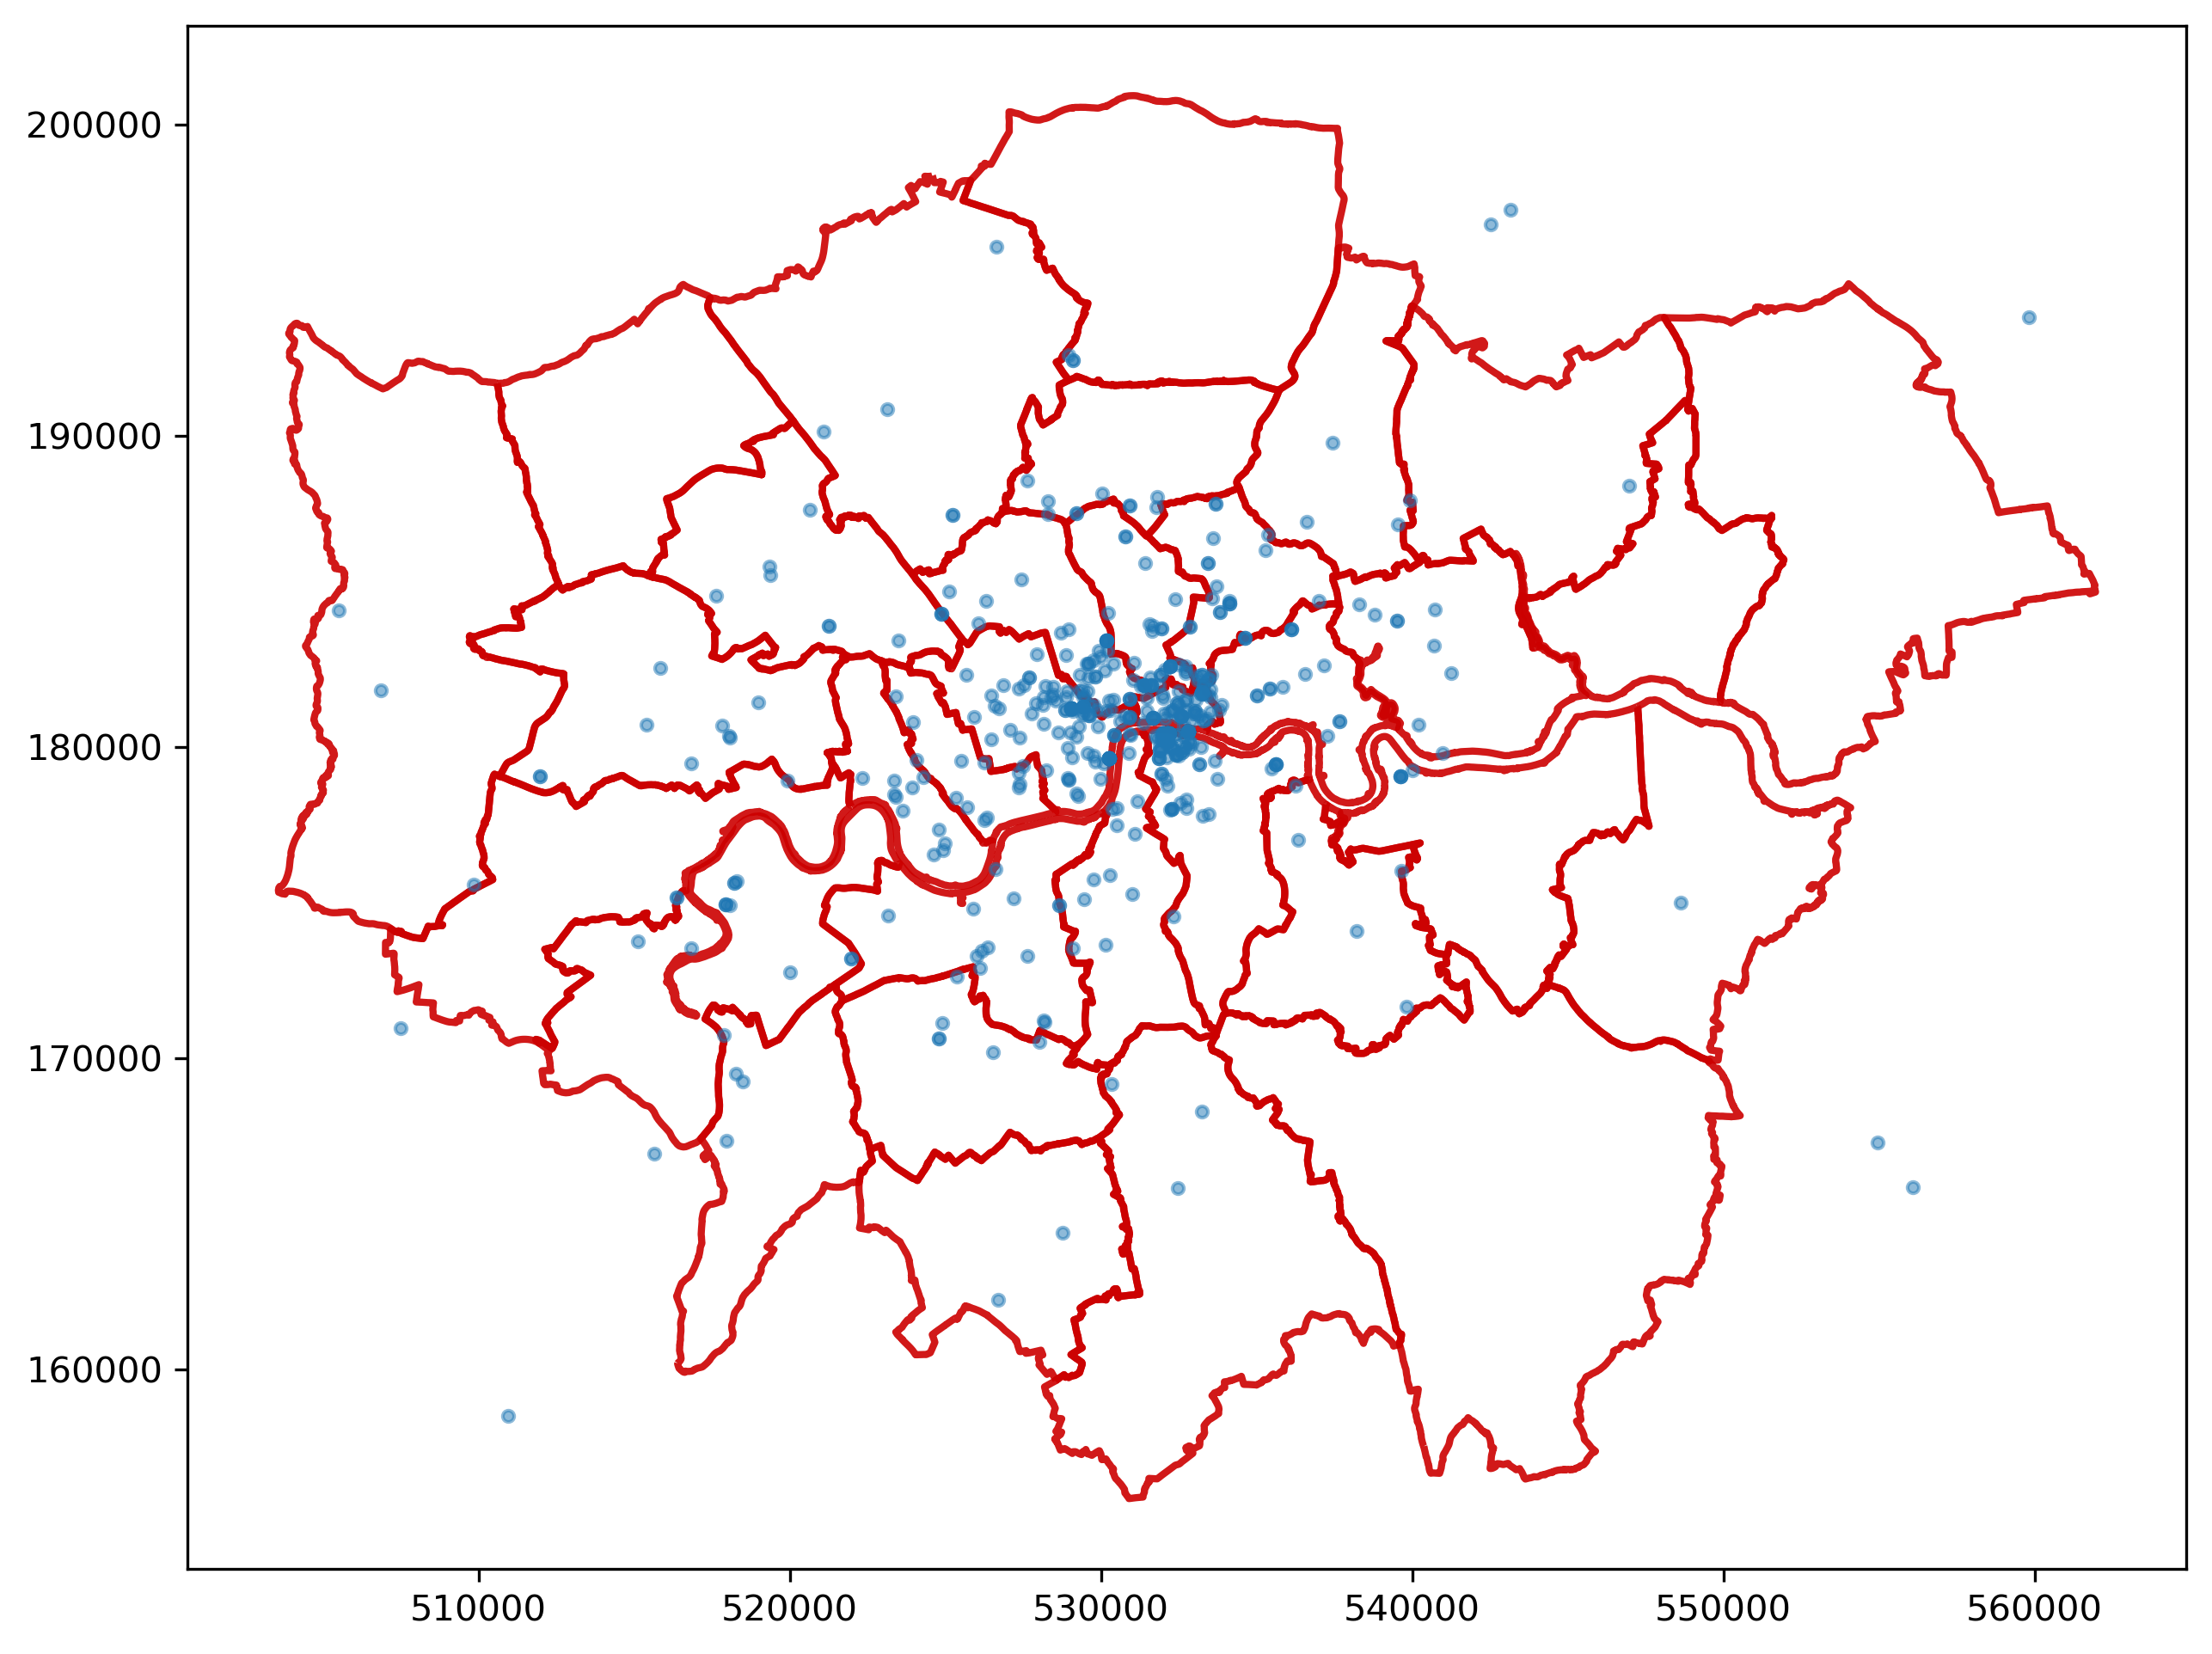

In [10]:
fig,ax = plt.subplots(figsize=(10,9),dpi=300)

#filter study area
xmin, ymin, xmax, ymax = gdf_boros.total_bounds
gdf_seachersx = gdf_seachers.cx[xmin:xmax, ymin:ymax]
print(f'{gdf_seachersx.shape[0]-gdf_seachers.shape[0]} raws removed')

gdf_boros.plot(edgecolor=(0.8, 0, 0, 0.9), facecolor='none', linewidth=2, ax=ax,zorder=1)
gdf_seachersx.plot(alpha=.5,markersize=10,ax=ax,zorder=2)

In [11]:
df_locs = pd.read_csv(DATA_DIR+"/requested-locations.csv")
gdf_locs = df_to_gdf(df_locs, lon="longitude", lat="latitude",scproj='epsg:4326',proj='epsg:27700')

Geo Data frame is 319 x 4


3 raws removed


<AxesSubplot:>

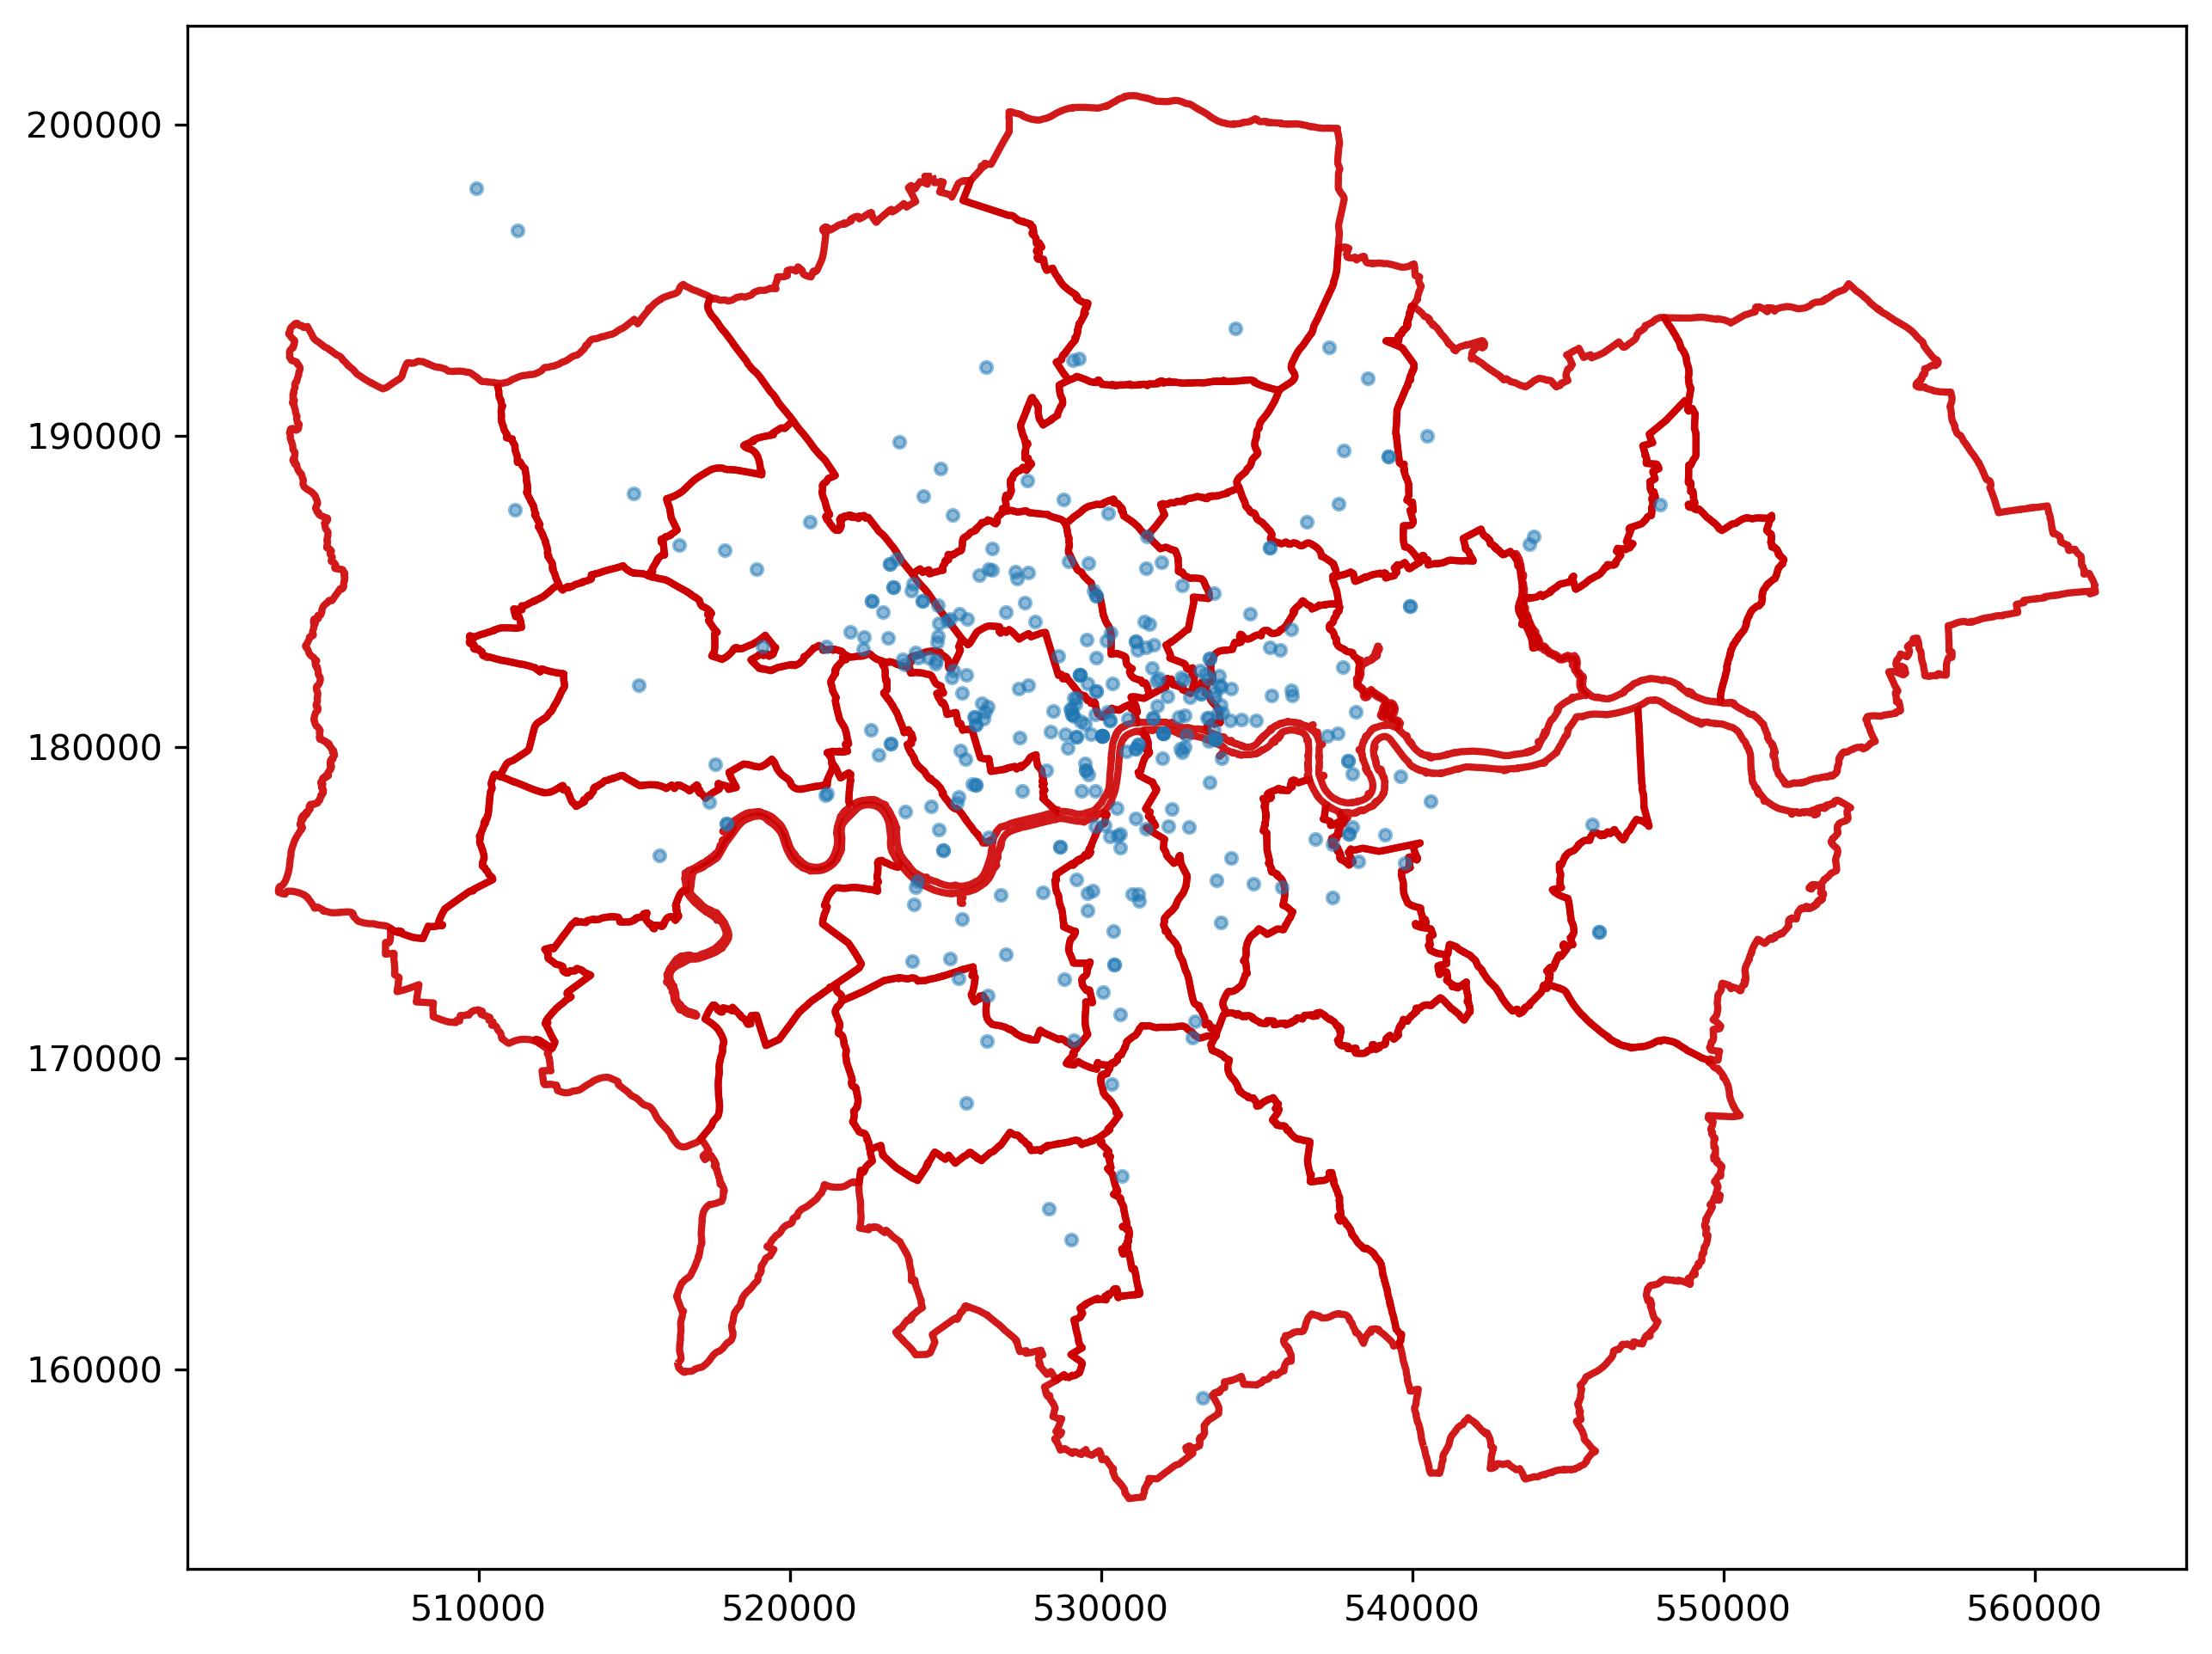

In [12]:
fig,ax = plt.subplots(figsize=(10,9),dpi=300)

#filter study area
xmin, ymin, xmax, ymax = gdf_boros.total_bounds
gdf_locsx = gdf_locs.cx[xmin:xmax, ymin:ymax]
print(f'{-gdf_locsx.shape[0]+gdf_locs.shape[0]} raws removed')

gdf_boros.plot(edgecolor=(0.8, 0, 0, 0.9), facecolor='none', linewidth=2, ax=ax,zorder=1)
gdf_locsx.plot(alpha=.5,markersize=10,ax=ax,zorder=2)

### Lines and parking

#### parkings

In [116]:
# https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
r = requests.get("https://cycling.data.tfl.gov.uk/CyclingInfrastructure/data/points/cycle_parking.json")
r.raise_for_status()

f2 = open(DATA_DIR+'/cycle_parking.geojson', 'w')
f2.write(json.dumps(r.json()))
f2.close()

<AxesSubplot:>

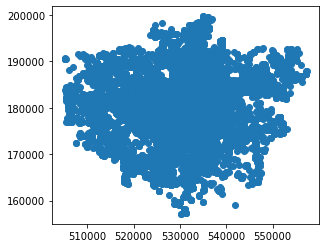

In [124]:
gdf_parking = gpd.read_file(DATA_DIR+'/cycle_parking.geojson').to_crs("epsg:27700") # to dict
gdf_parking.plot()

In [1]:
# parking ## json索引后是列表 挺奇怪的

In [2]:
# [i['properties'].update({"geometry":i['geometry']}) for i in parking["features"]] ## TODO

<AxesSubplot:>

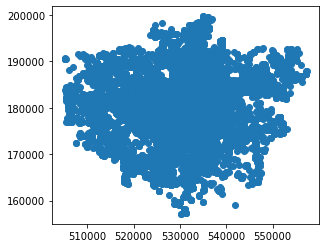

In [173]:
df_parking = pd.DataFrame.from_records([i['properties'] for i in parking["features"]])

df_parking["geometry"] = df_parking["geometry"].apply(shapely.geometry.shape)

gdf_parking = gpd.GeoDataFrame(df_parking,crs="epsg:4326").set_geometry('geometry').to_crs("epsg:27700")
gdf_parking.to_excel(DATA_DIR+"/parkings.xls")
gdf_parking.plot()

In [187]:
gdf_parking.to_file(DATA_DIR+"/geo/parking.shp")

### Lines

In [174]:
# # https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
# r = requests.get("https://cycling.data.tfl.gov.uk/CyclingInfrastructure/data/lines/cycle_lane_track.json")
# r.raise_for_status()

# f2 = open(DATA_DIR+'/cycle_lane_track.json', 'w')
# f2.write(json.dumps(r.json()))
# f2.close()

In [175]:
f = open(DATA_DIR+'/cycle_lane_track.json', 'r')
lane = json.loads(f.read()) # to dict
f.close()

In [3]:
#[i['properties'].update({"geometry":i['geometry']}) for i in lane["features"]] # run once

<AxesSubplot:>

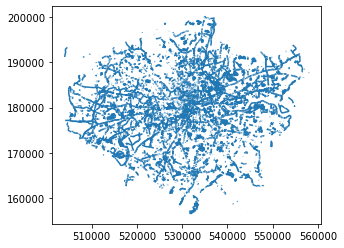

In [184]:
df_lane = pd.DataFrame.from_records([i['properties'] for i in lane["features"]])

df_lane["geometry"] = df_lane["geometry"].apply(shapely.geometry.shape)

gdf_lane = gpd.GeoDataFrame(df_lane,crs="epsg:4326").set_geometry('geometry').to_crs("epsg:27700")
gdf_lane = gdf_lane.drop(columns=["PHOTO1_URL","PHOTO2_URL"],axis=1)
gdf_lane.to_csv(DATA_DIR+"/lane.csv")
gdf_lane.plot()

In [186]:
gdf_lane.to_file(DATA_DIR+"/geo/lane.shp")

## Spatial location operation research 

In [83]:
import requests
import sys
import json
import contextily as ctx

<AxesSubplot:>

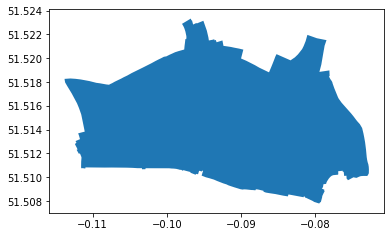

In [44]:
gdf_boros.to_crs("epsg:4326").loc[32:,:].plot()

In [93]:
bbx = gdf_boros.to_crs("epsg:4326").loc[32,"geometry"].bounds
bbx_str = ",".join(map(str,bbx))
bbx_str

bbx2 = gdf_boros.loc[32,"geometry"].bounds

In [47]:
apikey = "5195e3d09446fe83"
# https://github.com/cyclestreets/transporthack/blob/master/python/getcyclehire.py

In [48]:
url = f"https://api.cyclestreets.net/v2/trafficcounts.locations?key={apikey}&groupyears=1&bbox={bbx_str}"
r = requests.get(url)
j = r.json()

d = json.dumps(j)
open(DATA_DIR+"/CoLTrafficount.geojson", "w").write(d)

In [360]:
gdf_trffic = gpd.read_file(DATA_DIR+"/CoLTrafficount.geojson").to_crs("epsg:27700")

gdf_trffic["cycles_2016"] = gdf_trffic.cycles.apply(lambda i:int(i.split(",")[-1])) ## get cycle counts in 2016

In [402]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

y = list(map(int,gdf_trffic.cycles[1].split(",")))
x = [2000+i for i in range(17)]

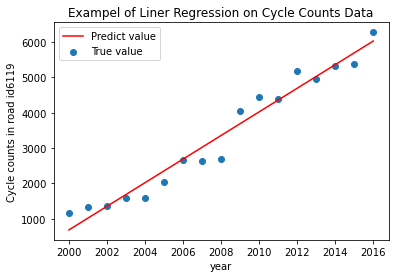

In [413]:
x1 = sm.add_constant(x) # 若模型中有截距，必须有这一步

model = sm.OLS(y, x1).fit() # 构建最小二乘模型并拟合

predicts = model.predict() # 模型的预测值
plt.scatter(x, y, label='True value') # 散点图
plt.plot(x, predicts, color = 'red', label='Predict value')
plt.title("Exampel of Liner Regression on Cycle Counts Data")
plt.legend() # 显示图例，即每条线对应 label 中的内容
plt.xlabel("year")
plt.ylabel("Cycle counts in road id6119")
plt.savefig("ols.png",dpi=400)

(180500.0, 182500.0)

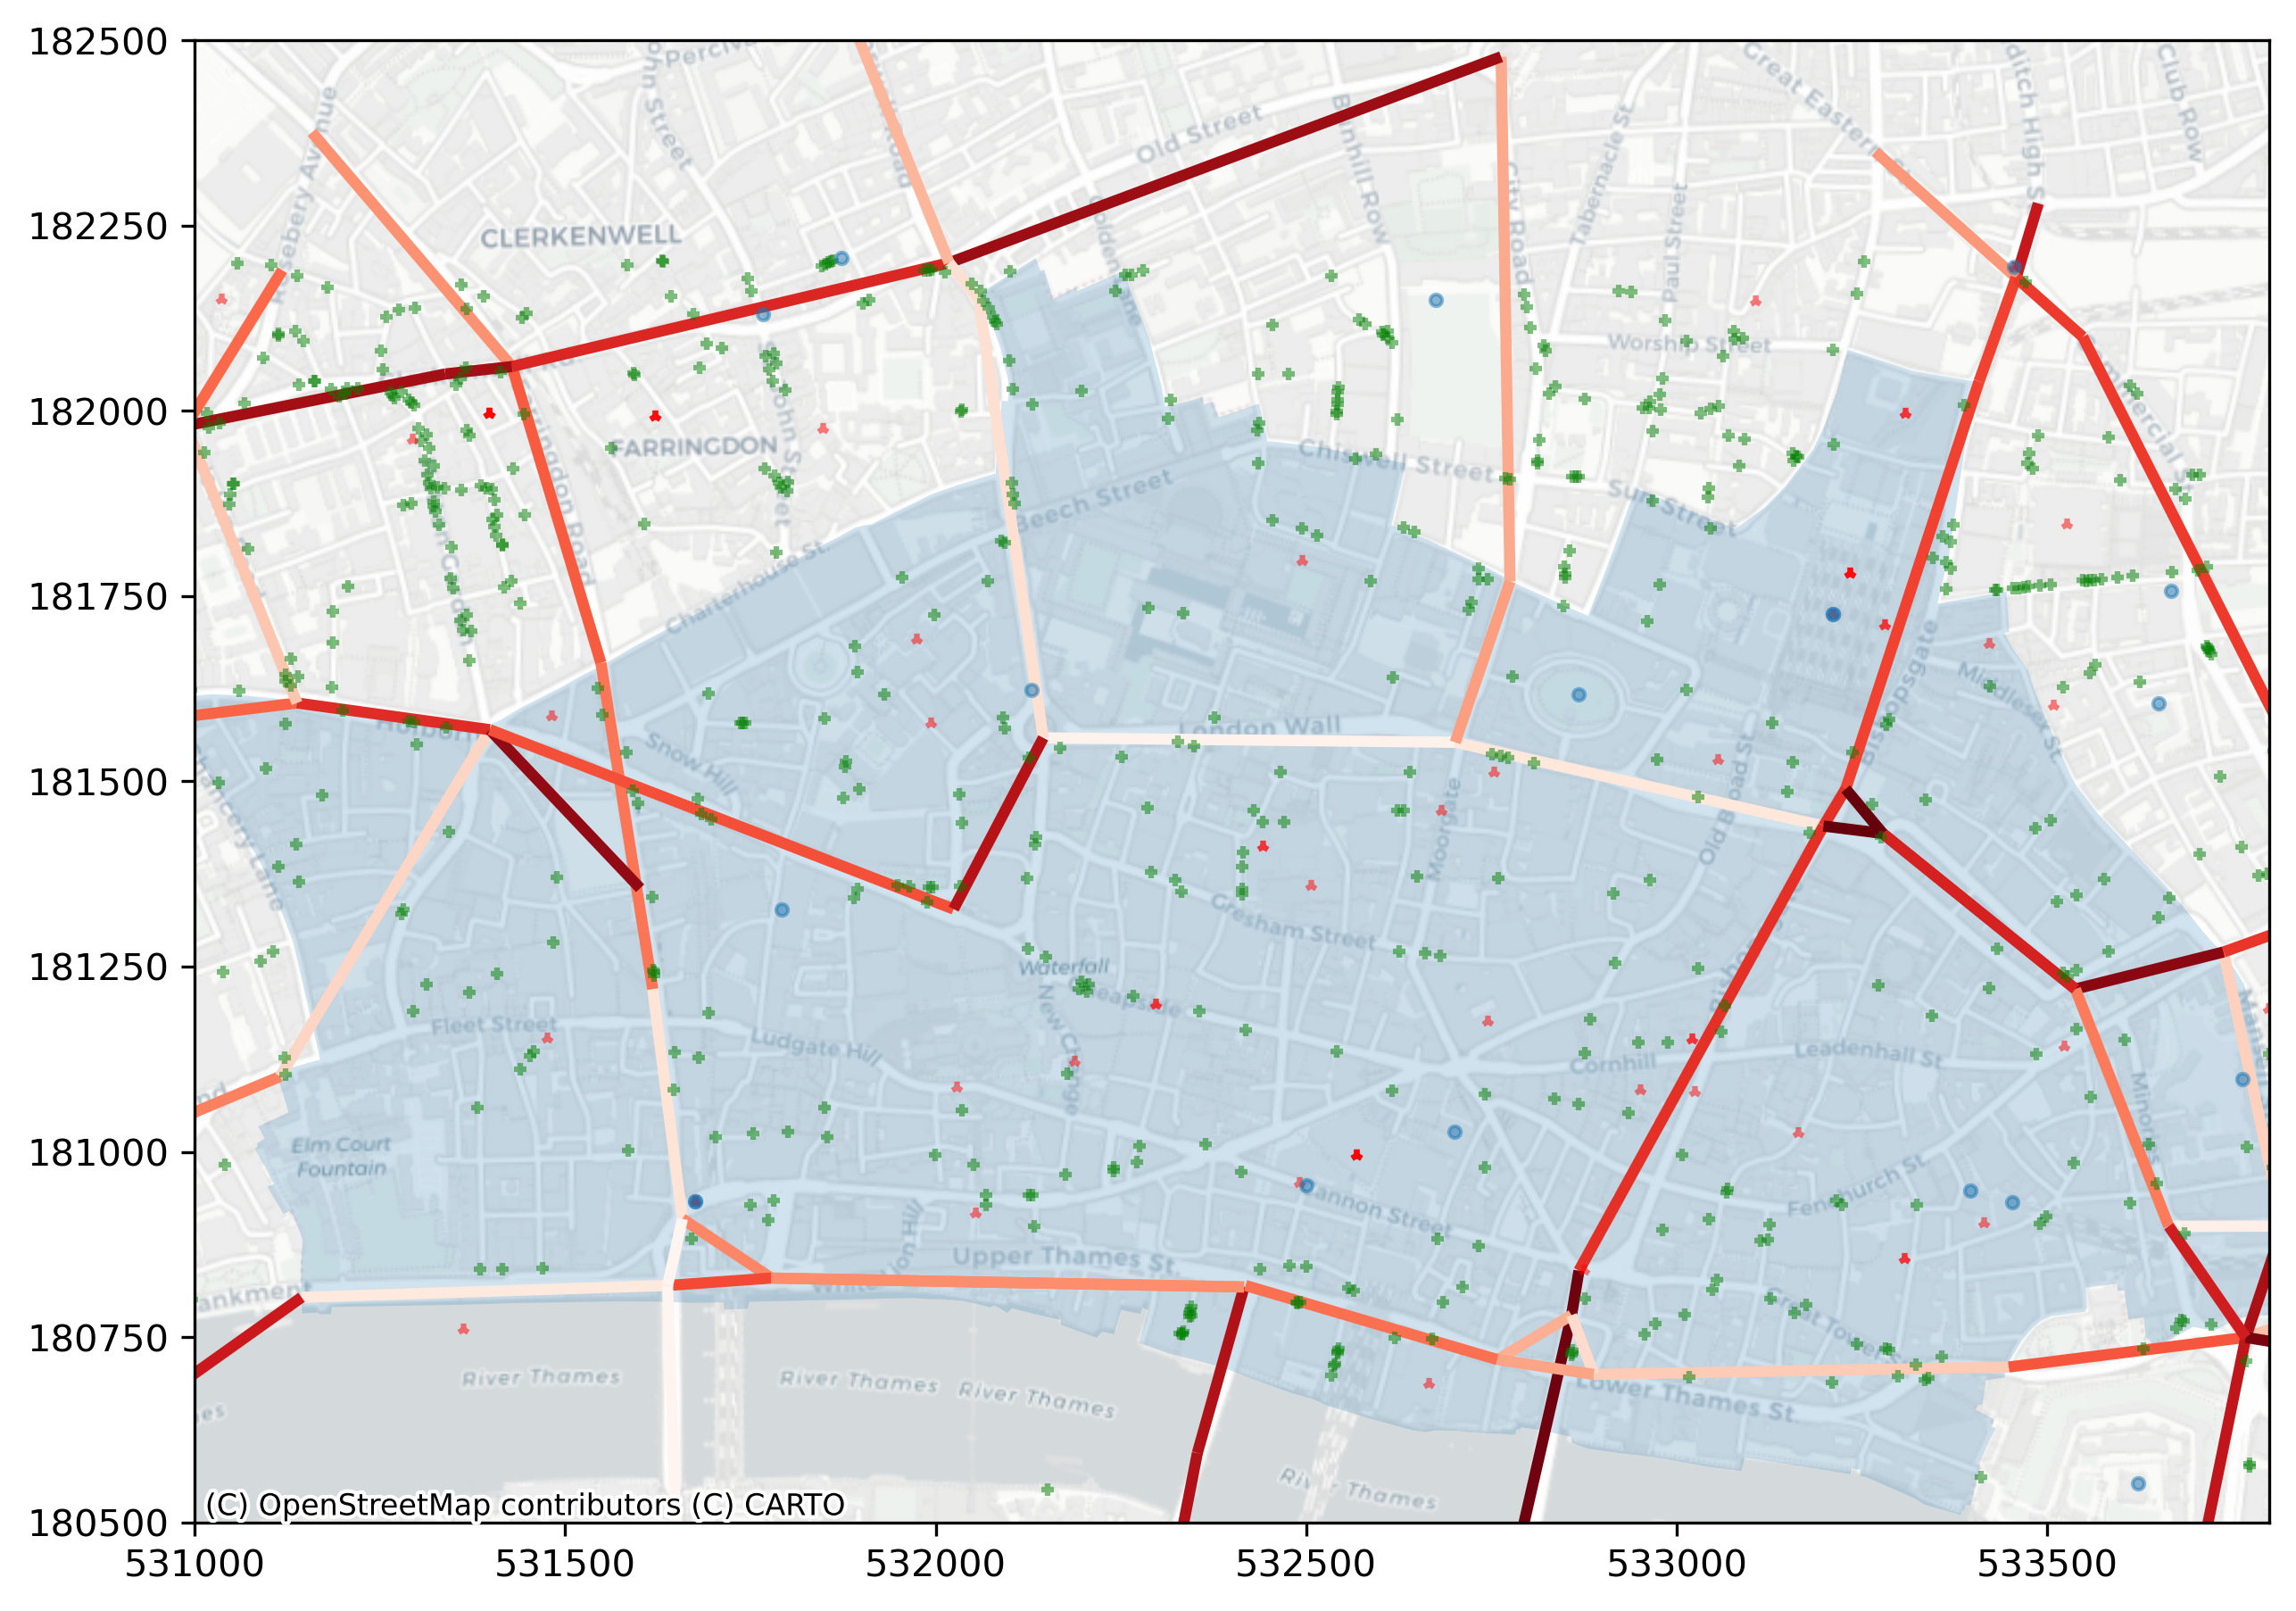

In [125]:
fig,ax = plt.subplots(figsize=(10,9),dpi=300)

gdf_trffic.plot(column="cycles_2016",cmap="Reds",ax=ax,lw=3)

gdf_boros.loc[32:,:].plot(ax=ax, alpha=0.2)
ctx.add_basemap(ax,crs="epsg:27700",source=ctx.providers.CartoDB.Positron)

xmin, ymin, xmax, ymax = bbx2
gdf_parkingsx = gdf_parking.cx[xmin:xmax, ymin:ymax]
gdf_parkingsx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,c="g",marker="+")

#searchers
xmin, ymin, xmax, ymax = bbx2
gdf_seachersx = gdf_seachers.cx[xmin:xmax, ymin:ymax]
gdf_seachersx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,c="r",marker="2")

#locs
xmin, ymin, xmax, ymax = bbx2
gdf_locsx = gdf_locs.cx[xmin:xmax, ymin:ymax]

gdf_locsx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,)
ax.set_xlim([531000,533800])
ax.set_ylim([180500,182500])

In [92]:
gdf_seachersx

(-0.11379547759049664,
 51.50779037206396,
 -0.07272318912265224,
 51.52332307170757)

In [355]:
def get_weighted_cost(x):
    number = x["nearest_point"]
    col_name = f"disto_{number}"
    return x["cycles_2016"]*x[col_name]

def get_total_cost(gdf_trffic, gdf_chioce_cur, n):

    for i in range(gdf_chioce_cur.shape[0]):
        
        pnt = gdf_chioce_cur.iloc[i,:].geometry

        gdf_trffic[f"disto_{gdf_chioce_cur.index[i]}"] = gdf_trffic.apply(lambda x: pnt.distance(x.geometry),axis=1)
        
    gdf_trffic["nearest_point"] = gdf_trffic.iloc[:,-n:].apply(lambda x: int(x.idxmin().split("_")[1]),axis=1)

    gdf_trffic["weighted_distance"] = gdf_trffic.apply(lambda x : get_weighted_cost(x),axis=1)

    cost_dic = gdf_trffic.groupby("nearest_point")["weighted_distance"].sum().to_dict() ## 需求强度

    sum_cost_dic = sum(cost_dic.values())
    
    return sum_cost_dic,gdf_trffic

In [361]:
sum_cost_dic,gdf_trffic_1 = get_total_cost(gdf_trffic, gdf_chioce_cur, n=5)

<AxesSubplot:>

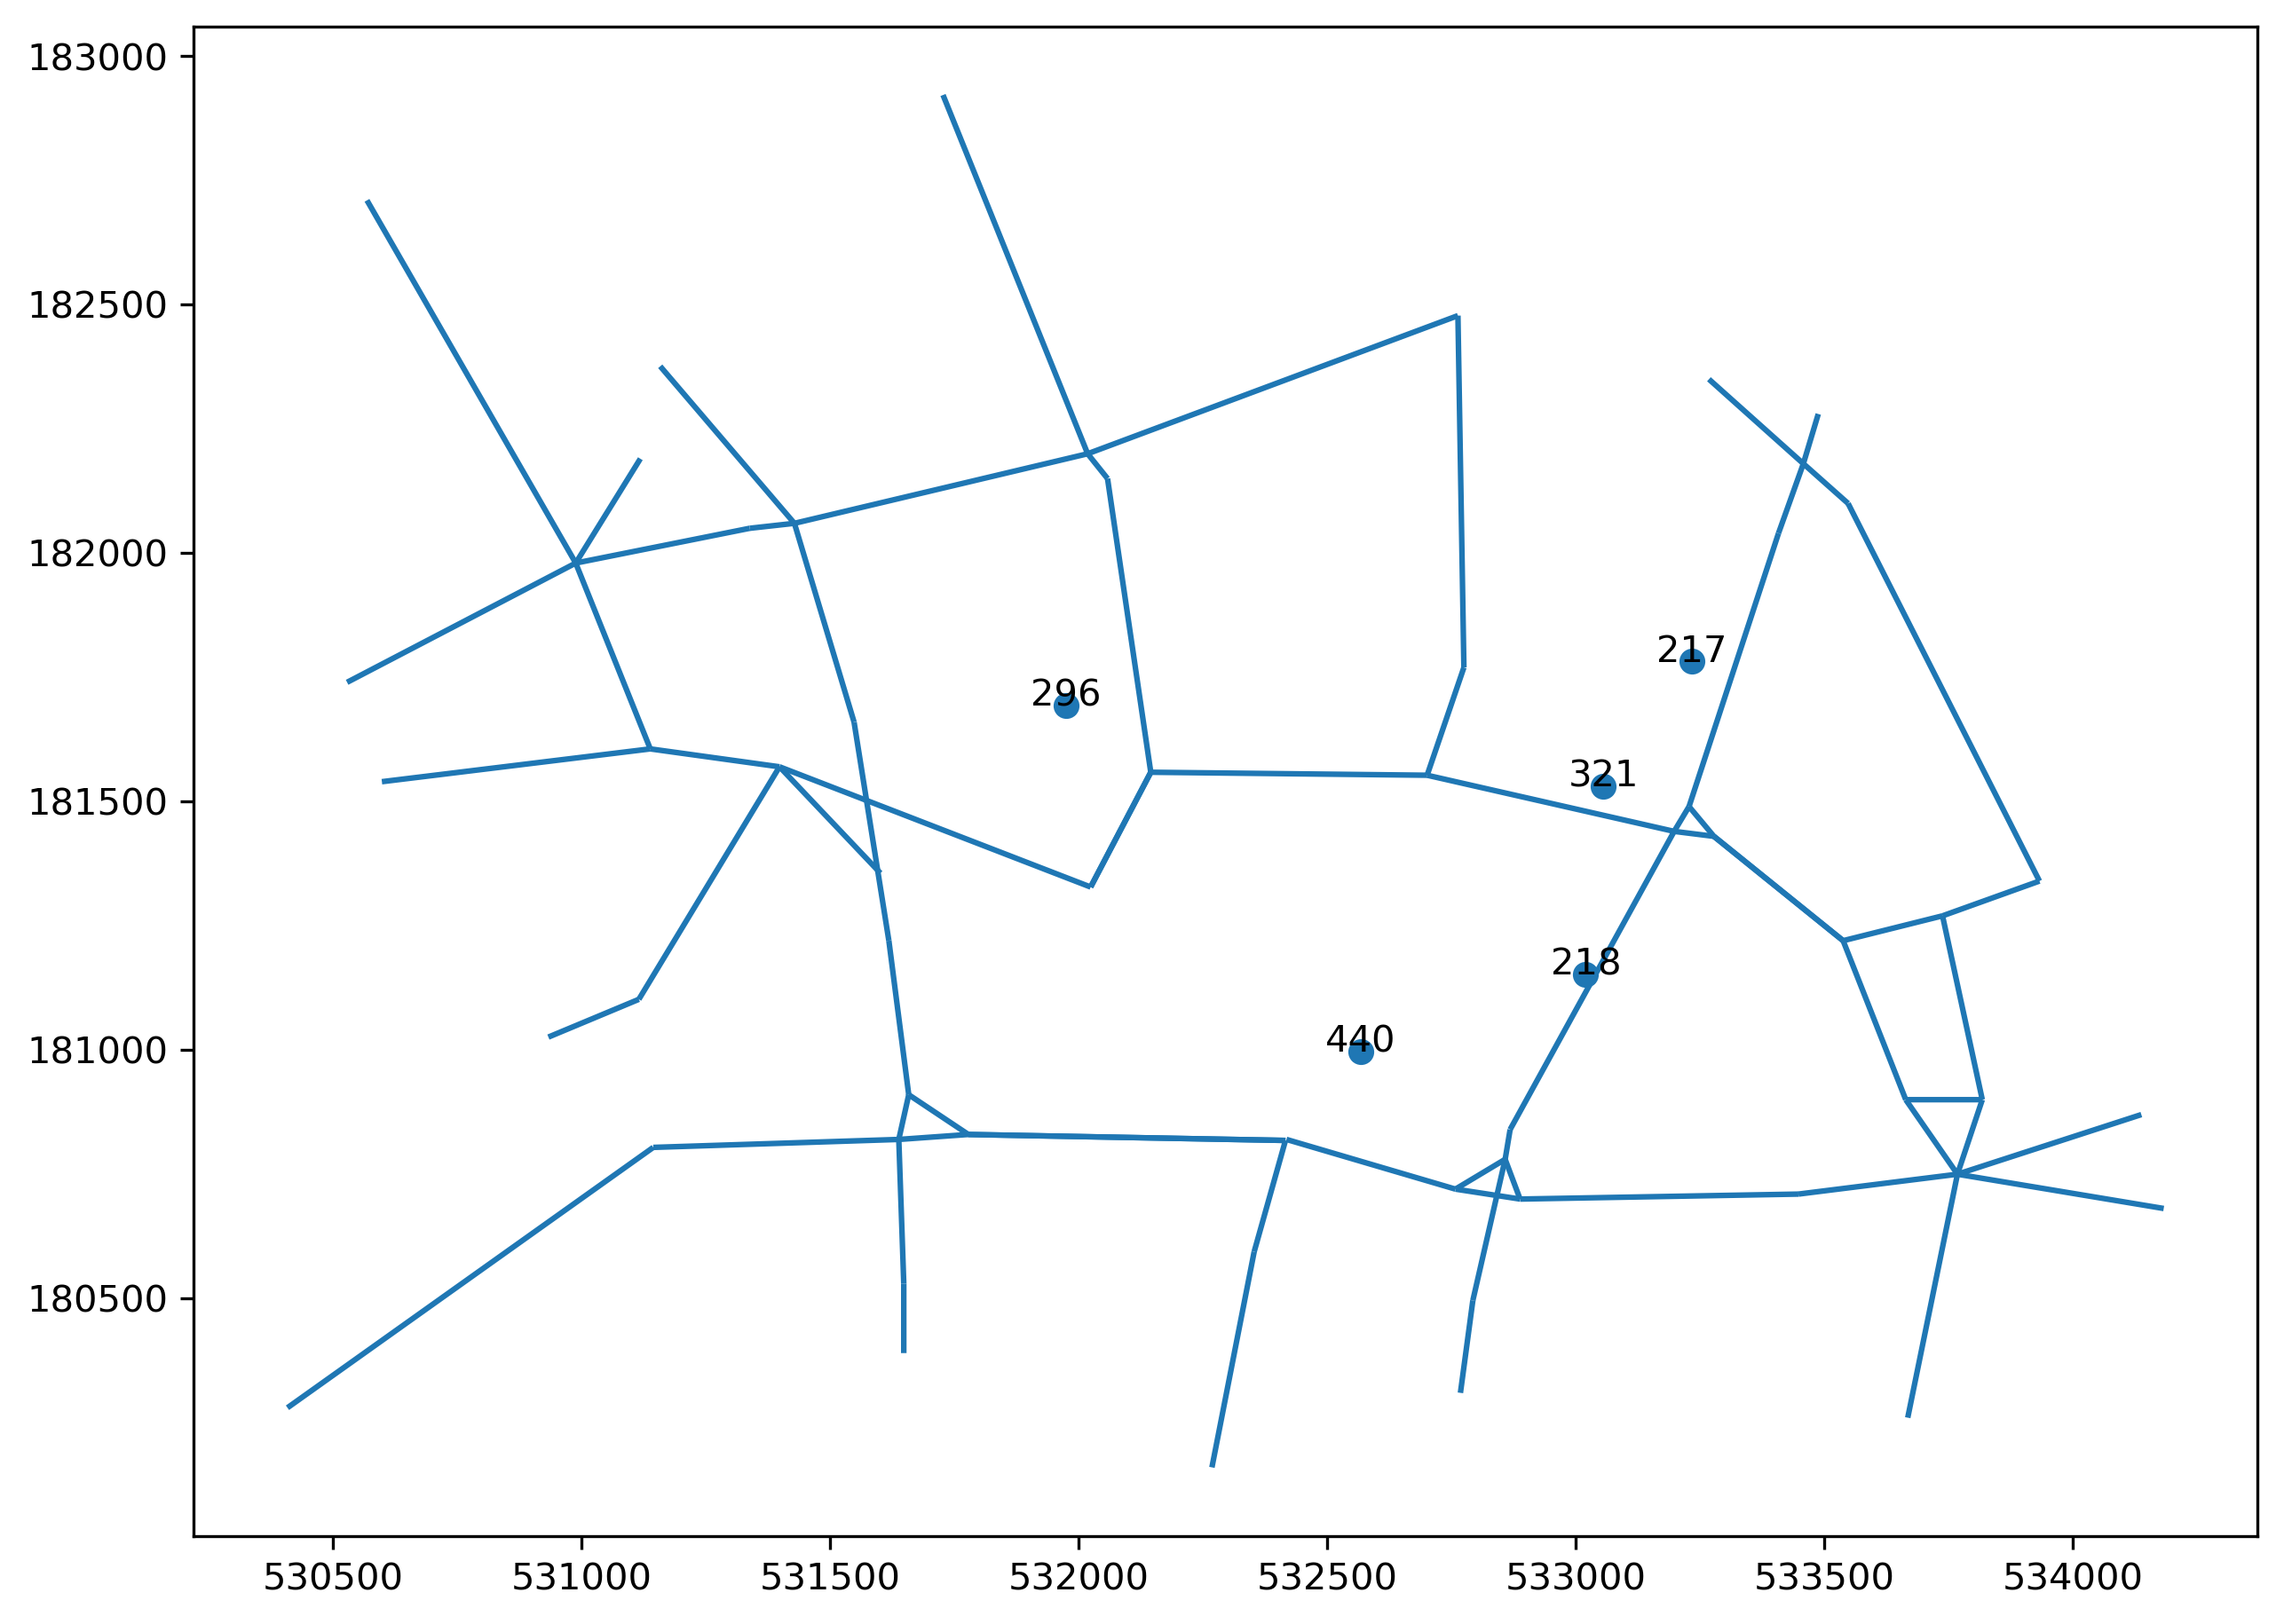

In [194]:
## plot to check 
fig,ax = plt.subplots(figsize=(10,9),dpi=300)
gdf_parking_cur.apply(lambda x: ax.annotate(s=x.name, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
gdf_trffic_new.plot(ax=ax)
gdf_parking_cur.plot(ax=ax)

## greedy solving

In [293]:
def greedy_solving(gdf_seachersx, gdf_trffic, n= 7):
    log = {}
    
    gdf_chioce_cur = gdf_seachersx.sample(n)
    
    chioce_idx = list(gdf_chioce_cur.index)
    
    cur_costs = get_total_cost(gdf_trffic.copy(), gdf_chioce_cur,n)

    log[",".join(map(str,chioce_idx))] = cur_costs
    
    not_visited = [x for x in list(gdf_seachersx.index) if x not in list(gdf_chioce_cur.index)]

    np.random.shuffle(not_visited)

    while not_visited:
        to_be_visit = not_visited.pop()
        print(f"visiting {to_be_visit}")
        inserted_costs = [1e10 for i in range(n)]

        for i in range(n): ## 替代每一个
            chioce_temp_idx =  chioce_idx.copy()

            chioce_temp_idx[i] = to_be_visit
            # print(chioce_temp_idx)
            gdf_chioce_temp = gdf_seachersx.loc[chioce_temp_idx,:]
            inserted_costs[i] = get_total_cost(gdf_trffic.copy(), gdf_chioce_temp,n)

        min_insert_cost = min(inserted_costs)
        min_insert_idx = inserted_costs.index(min(inserted_costs))

        if min_insert_cost < cur_costs:

            print(f"Current costs from {cur_costs} to {min_insert_cost}")
            chioce_idx[min_insert_idx] = to_be_visit
            cur_costs = min_insert_cost
            log[",".join(map(str,chioce_idx))] = cur_costs
            
    #print(f"Best chioce is {chioce_idx}")
    return chioce_idx,log

In [330]:
chioce_idx, log = greedy_solving(gdf_seachersx, gdf_trffic, n= 5)

visiting 411
Current costs from 154735130.73618144 to 128710607.56059694
visiting 459
Current costs from 128710607.56059694 to 115573940.47590826
visiting 418
visiting 258
Current costs from 115573940.47590826 to 109817413.03847644
visiting 230
visiting 458
visiting 121
visiting 81
visiting 229
visiting 388
visiting 440
visiting 218
visiting 95
visiting 296
visiting 507
visiting 372
Current costs from 109817413.03847644 to 109175707.89070193
visiting 378
visiting 392
visiting 237
visiting 94
visiting 456
visiting 412
visiting 340
visiting 92
visiting 432
visiting 419
visiting 321
visiting 443
visiting 35
visiting 442
visiting 195
visiting 154
Current costs from 109175707.89070193 to 83487943.62929606
visiting 266
visiting 534
visiting 135
visiting 130
visiting 417
visiting 460
visiting 377
visiting 170
Current costs from 83487943.62929606 to 77111395.42422552
visiting 104
Current costs from 77111395.42422552 to 69366833.12213665
visiting 96
visiting 173
visiting 531
visiting 93
visitin

In [334]:
np.save(DATA_DIR+'/log.npy', log) 

### 可视化

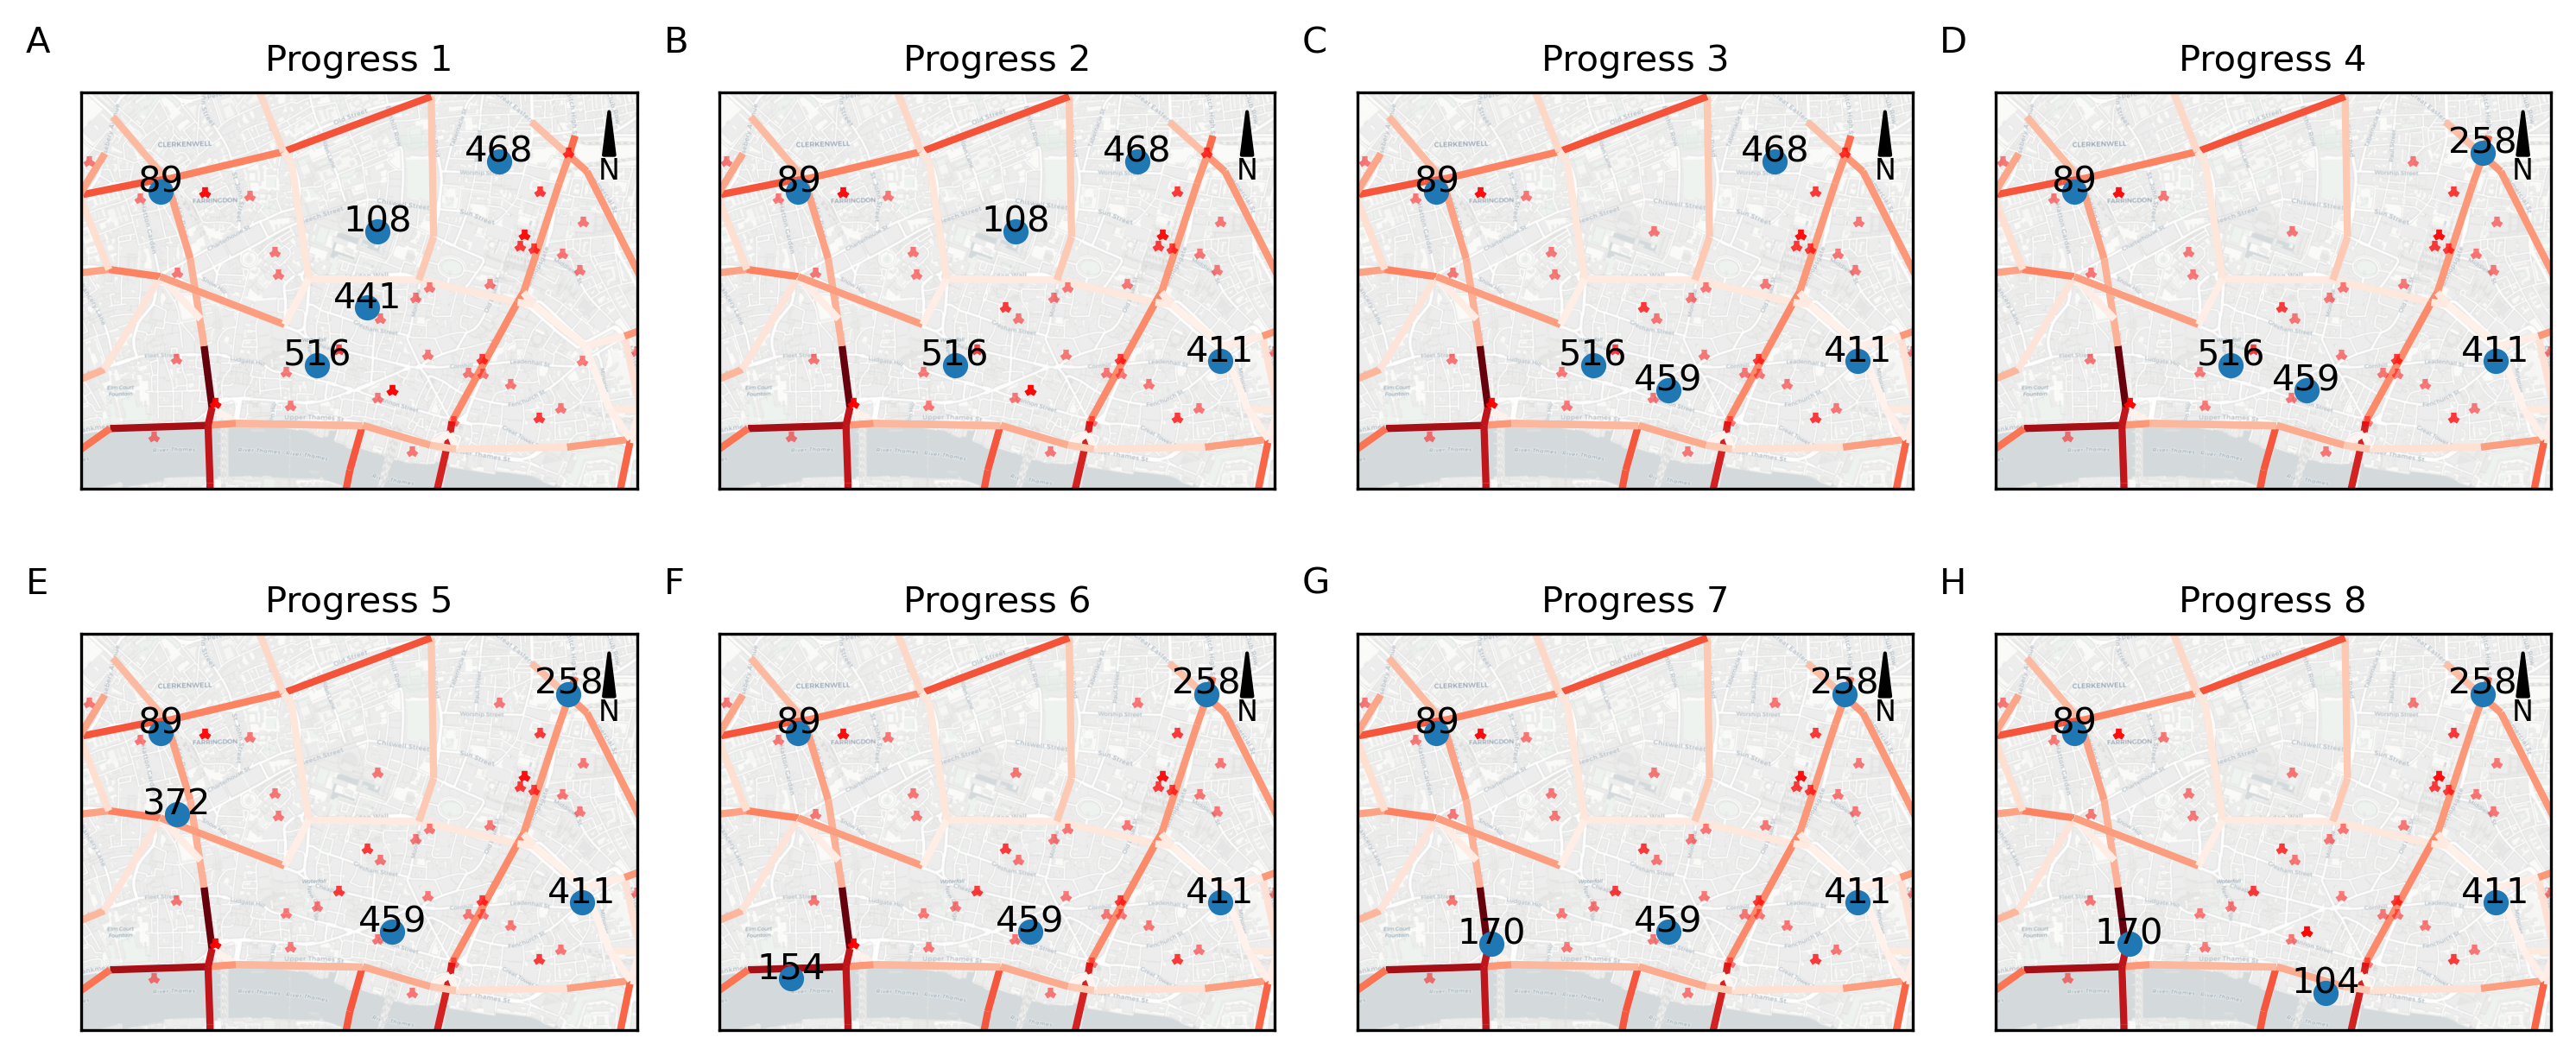

In [349]:
font_subtitle = {'family' : 'sans-serif','weight' : 'normal','size'   : 10}

f,ax = plt.subplots(2,4,figsize=(10,4.5),dpi=300,
                    subplot_kw=dict(aspect="equal"))  ## same scaling from data to plot units for x and y
ax = ax.flatten()
for i in range(len(log)):
    chioce_temp_idx = list(map(int,list(log.keys())[i].split(",")))
    gdf_choice_cur = gdf_seachersx.loc[chioce_temp_idx,:]
    
    gdf_trffic.plot(column="cycles_2016",cmap="Reds",ax=ax[i],lw=2,zorder=1)
    
    gdf_seachersx.plot(alpha=.5,markersize=10,ax=ax[i],c="r",marker="2")
    
    gdf_choice_cur.apply(lambda x: ax[i].annotate(s=x.name, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
    gdf_choice_cur.plot(ax=ax[i],zorder=2) 

    ctx.add_basemap(ax[i],crs="epsg:27700",source=ctx.providers.CartoDB.Positron,attribution=False,reset_extent=True)
    
    ax[i].tick_params(axis=u'both',which=u'both',labelright=0,labelleft =0,labelbottom=0,left=0,bottom=0,top=0,right=0,labelsize=8)
    ax[i].set_xlim([531000,533800])
    ax[i].set_ylim([180500,182500])
    
    ax[i].set_title(f"Progress {i+1}",font = font_subtitle)
    
    ax[i].text(-0.1,1.1,"ABCDEFGH"[i],font=font_subtitle, transform=ax[i].transAxes)
    
    x, y, arrow_length = 0.95, 0.95, 0.15
    ax[i].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                   arrowprops=dict(facecolor='black', width=1.5, headwidth=3),
                   ha='center', va='center', fontsize=8, xycoords=ax[i].transAxes)
    
plt.tight_layout()
f.savefig("Opt.png",dpi=400)

In [365]:
gdf_trffic_1.nearest_point.unique()

array([277, 412,  89, 175], dtype=int64)

In [4]:
#gdf_choice_cur = gdf_seachersx.loc[chioce_temp_idx,:].reset_index()

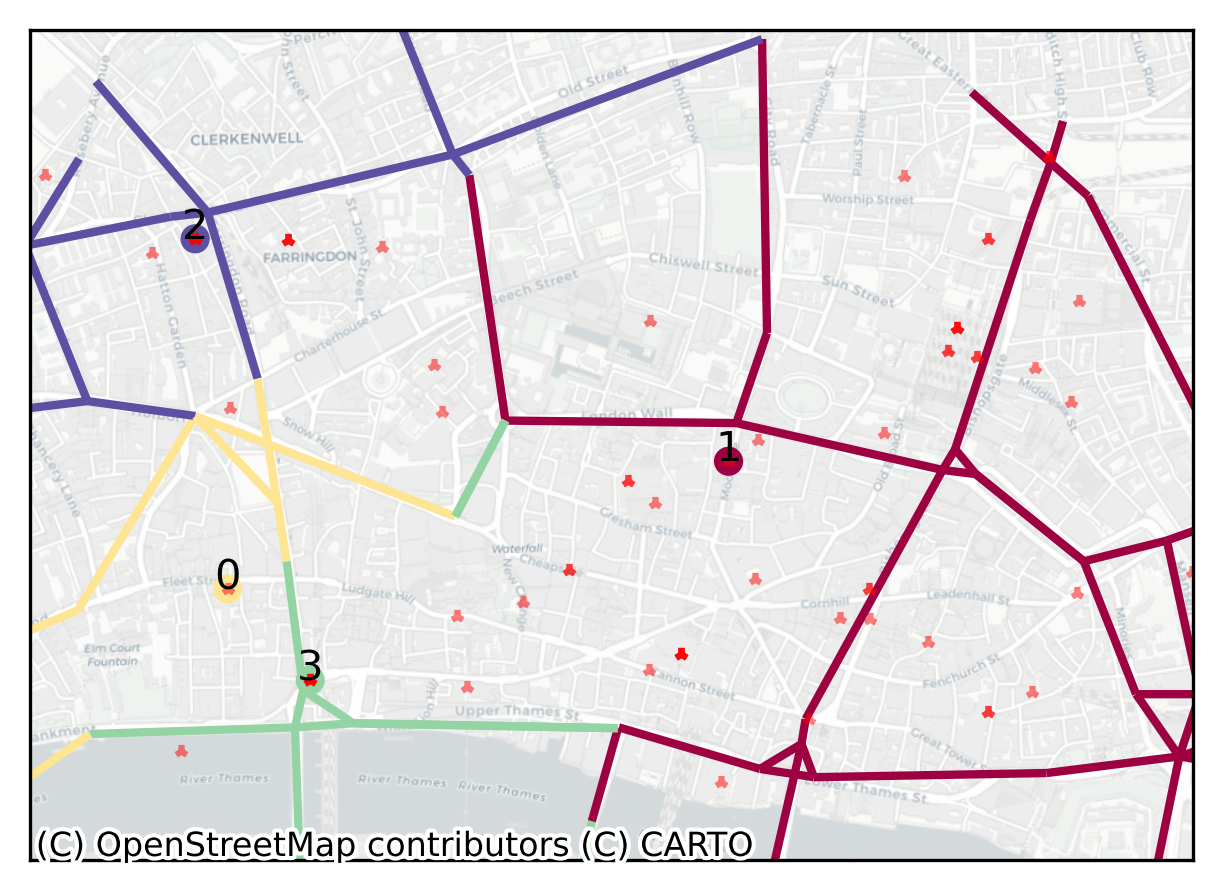

In [379]:
fig,ax = plt.subplots(figsize=(5,4.5),dpi=300)

gdf_trffic_1.plot(column="nearest_point",cmap="Spectral_r",ax=ax,lw=2)

chioce_temp_idx = list(gdf_trffic_1.nearest_point.unique())
gdf_choice_cur = gdf_seachersx.loc[chioce_temp_idx,:].reset_index()
gdf_choice_cur.apply(lambda x: ax.annotate(s=x.name, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
gdf_choice_cur.plot(ax=ax,column="index",cmap="Spectral_r",zorder=2)

# gdf_boros.loc[32:,:].plot(ax=ax, alpha=0.2)
ctx.add_basemap(ax,crs="epsg:27700",source=ctx.providers.CartoDB.Positron)

# xmin, ymin, xmax, ymax = bbx2
# gdf_parkingsx = gdf_parking.cx[xmin:xmax, ymin:ymax]
# gdf_parkingsx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,c="g",marker="+")

#searchers
xmin, ymin, xmax, ymax = bbx2
gdf_seachersx = gdf_seachers.cx[xmin:xmax, ymin:ymax]
gdf_seachersx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,c="r",marker="2")

# #locs
# xmin, ymin, xmax, ymax = bbx2
# gdf_locsx = gdf_locs.cx[xmin:xmax, ymin:ymax]

# gdf_locsx.plot(alpha=.5,markersize=10,ax=ax,zorder=2,)

ax.tick_params(axis=u'both',which=u'both',labelright=0,labelleft =0,labelbottom=0,left=0,bottom=0,top=0,right=0,labelsize=8)
ax.set_xlim([531000,533800])
ax.set_ylim([180500,182500])
fig.savefig("demos.png",dpi=400)

$$
Predicted\ Parking\ Demand = k \times Predicted\ Cycle\ Counts - Current\ Parking\ Capacity 
$$

$$
Target: maximize  T = \sigma^N_{j=1} \sigma^M_{i=1} w_i d_{ij} b_{ij}

Subject to: b_ij &=& {0,1}
    i &in& potential locations 
$$